In [1]:
#SELECTION DEFINITION

NEW_SELECTION = (
    "((Dst_M - D0_M) > 143) & ((Dst_M - D0_M) < 148) & "
    "(K_IPCHI2_OWNPV > 3) & (pi_IPCHI2_OWNPV > 3) & "
    "(K_TRACK_CHI2NDOF < 3.) & (pi_TRACK_CHI2NDOF < 3.) & "
    "(K_PT > 500.) & (pi_PT > 500.) & "
    "(K_hasRich == 1) & (pi_hasRich == 1) & "
    "(mp_TRACK_CHI2NDOF < 3.) & "
    "(mm_TRACK_CHI2NDOF < 3.) & "
    "(mp_isMuon == 1) & (mm_isMuon == 1) & "
    "(mp_PIDmu > 0) & (mm_PIDmu > 0) & "
    "(mp_PT > 250) & (mm_PT > 250) & "
    "(mp_IPCHI2_OWNPV > 3.) & (mm_IPCHI2_OWNPV > 3.) & "
    "(Jpsi_M < 3127) & (Jpsi_M > 3067) & "
    "(Bc_ENDVERTEX_CHI2 < 4.) & "
    "(Bc_IPCHI2_OWNPV < 8.) & "
    "(Bc_DIRA_OWNPV > 0.998) &"
    "(D0_ENDVERTEX_CHI2 < 8.) &"
    "(D0_M > 1835) & (D0_M < 1895) &"
    "(K_ProbNNghost < 0.3) & (pi_ProbNNghost < 0.3) & "
    "(mm_ProbNNghost < 0.3) & (mp_ProbNNghost < 0.3) & "
    "(K_ProbNNk > 0.1) & (pi_ProbNNpi > 0.1) & "
    "(Jpsi_ENDVERTEX_CHI2 < 9.) &"
    "(Dst_ENDVERTEX_CHI2 < 9.) &"
    "(abs(Dst_M - 2010.) < 30.) &"
    "(Dst_PT > 2500.) &"
    "(pi_soft_TRACK_CHI2NDOF < 3.) &"
    "(pi_soft_TRACK_GhostProb < 0.3)"
)

In [2]:

#IMPORTING LIBRARIES
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
import zfit

from xgboost import XGBClassifier, callback, plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import pickle
import optuna
import joblib
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import random 

from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests import Discovery
from hepstats.hypotests.parameters import POI

/afs/cern.ch/user/k/ktrofimi/.venv/lib64/python3.9/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
2025-03-11 15:48:22.098775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741704502.113381  800692 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741704502.117265  800692 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/afs/cern.ch/user/k/ktrofimi/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarni

In [3]:
#LOADING DATASET

files_simu = [
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2011_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2011_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2012_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2012_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2015_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2015_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2016_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2016_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2017_MagDown.root',
    # '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2017_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2018_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2018_MagUp.root',
]

files_real_data = [
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2011_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2011_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2012_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2012_MagUp.root',
    # '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2015_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2015_MagUp.root',
    # '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2016_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2016_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2017_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2017_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2018_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2018_MagUp.root',
]
simu_data = uproot.concatenate(files_simu, cut = f"{NEW_SELECTION} & (Bc_BKGCAT == 0)", library='pd')
real_data = uproot.concatenate(files_real_data, cut = f"{NEW_SELECTION} & ((Bc_FullDTF_M < 6250.) | (Bc_FullDTF_M > 6300.))", library='pd')
real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']


/tmp/ktrofimi/ipykernel_800692/2247319782.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
/tmp/ktrofimi/ipykernel_800692/2247319782.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']


In [4]:
#FUNCTION FOR PLOTTING
def plot_model_with_pulls_log(model, name, data, min, max, scale=1, nbins=50, plot_data=True):
    
    size_normal = len(data)
    lower, upper = data.data_range.limit1d
    x = np.linspace(lower, upper, num=1000)

    # Evaluate model PDF
    y = model.pdf(x) * size_normal / nbins * data.data_range.volume
    y *= scale
    fig = plt.figure(figsize=(8, 6))

    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05) 

    # Upper subplot: Model and Data with error bars
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(x, y, label="model", color="blue", linewidth=1)
    ax1.set_xlim(min, max)

    if plot_data:
        # Bin the data
        data_binned = data.to_binned(nbins)
        bin_centers = data_binned.axes[0].centers
        bin_widths = data_binned.axes[0].widths
        data_counts = data_binned.values()
        data_uncertainties = np.sqrt(data_counts)  # Poisson errors

        ax1.errorbar(
            bin_centers, data_counts, yerr=data_uncertainties, fmt='o', 
            color='orange', label="data", markersize=1, capsize=2
        )

    ax1.legend()
    ax1.set_ylabel("Counts")
    
    ax1.set_title(name)
    ax1.grid()

    # Lower subplot: Pulls visualization
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    if plot_data:
        # Compute pulls
        model_at_bins = model.pdf(bin_centers) * size_normal / nbins * data.data_range.volume
        pulls = (data_counts - model_at_bins) / data_uncertainties

        ax2.errorbar(
            bin_centers, pulls, yerr=1, fmt='o', 
            color='purple', label="pulls", markersize=1, capsize=2
        )
        ax2.axhline(0, color='black', linestyle='--', linewidth=1)
        ax2.set_ylim(-10, 10) 
        ax2.set_ylabel("Pulls")
        ax2.grid()
        ax2.legend()
    ax1.set_yscale('log')
    ax2.set_xlabel("Observable")
    plt.tight_layout()
    plt.show()

In [5]:
#FUNCTION FOR PLOTTING
def plot_model_with_pulls(model, name, data, min, max, scale=1, nbins=50, plot_data=True):
    
    size_normal = len(data)
    lower, upper = data.data_range.limit1d
    x = np.linspace(lower, upper, num=1000)

    # Evaluate model PDF
    y = model.pdf(x) * size_normal / nbins * data.data_range.volume
    y *= scale
    fig = plt.figure(figsize=(8, 6))

    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05) 

    # Upper subplot: Model and Data with error bars
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(x, y, label="model", color="blue", linewidth=1)
    ax1.set_xlim(min, max)

    if plot_data:
        # Bin the data
        data_binned = data.to_binned(nbins)
        bin_centers = data_binned.axes[0].centers
        bin_widths = data_binned.axes[0].widths
        data_counts = data_binned.values()
        data_uncertainties = np.sqrt(data_counts)  # Poisson errors

        ax1.errorbar(
            bin_centers, data_counts, yerr=data_uncertainties, fmt='o', 
            color='orange', label="data", markersize=1, capsize=2
        )

    ax1.legend()
    ax1.set_ylabel("Counts")
    
    ax1.set_title(name)
    ax1.grid()

    # Lower subplot: Pulls visualization
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    if plot_data:
        # Compute pulls
        model_at_bins = np.array(model.pdf(bin_centers)) * size_normal / nbins * data.data_range.volume

        pulls = (data_counts - model_at_bins) / data_uncertainties

        ax2.errorbar(
            bin_centers, pulls, yerr=1, fmt='o', 
            color='purple', label="pulls", markersize=1, capsize=2
        )
        ax2.axhline(0, color='black', linestyle='--', linewidth=1)
        ax2.set_ylim(-10, 10) 
        ax2.set_ylabel("Pulls")
        ax2.grid()
        ax2.legend()
    ax2.set_xlabel("Observable")
    plt.tight_layout()
    plt.show()

In [7]:
simu_data["min_mm_mp_PT"] = simu_data[["mm_PT", "mp_PT"]].min(axis=1)
simu_data["max_mm_mp_PT"] = simu_data[["mm_PT", "mp_PT"]].max(axis=1)

simu_data["min_K_pi_PT"] = simu_data[["K_PT", "pi_PT"]].min(axis=1)
simu_data["max_K_pi_PT"] = simu_data[["K_PT", "pi_PT"]].max(axis=1)

real_data["min_mm_mp_PT"] = real_data[["mm_PT", "mp_PT"]].min(axis=1)
real_data["max_mm_mp_PT"] = real_data[["mm_PT", "mp_PT"]].max(axis=1)

real_data["min_K_pi_PT"] = real_data[["K_PT", "pi_PT"]].min(axis=1)
real_data["max_K_pi_PT"] = real_data[["K_PT", "pi_PT"]].max(axis=1)


/tmp/ktrofimi/ipykernel_800692/789072450.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data["min_mm_mp_PT"] = simu_data[["mm_PT", "mp_PT"]].min(axis=1)
/tmp/ktrofimi/ipykernel_800692/789072450.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data["max_mm_mp_PT"] = simu_data[["mm_PT", "mp_PT"]].max(axis=1)
/tmp/ktrofimi/ipykernel_800692/789072450.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [8]:
#BDT training

feature_columns = [

    'min_mm_mp_PT',
    'max_mm_mp_PT',
    'Bc_ENDVERTEX_CHI2',
    'Bc_IPCHI2_OWNPV',

    'Bc_FD_OWNPV',
    'Jpsi_FD_ORIVX',
    'D0_FD_ORIVX',
    'min_K_pi_PT'
]
#PREPARING DATASET
# Separate features and labels
X_simu = simu_data[feature_columns]
y_simu = np.ones(len(simu_data))  # Label: 1 for simulation data

X_real = real_data[feature_columns]
y_real = np.zeros(len(real_data))  # Label: 0 for real data

# Combine features and labels
X_all = pd.concat([X_simu, X_real], ignore_index=True)
y_all = np.concatenate([y_simu, y_real]) 

print(f"SIMULATION set size: {X_simu.shape}")
print(f"REAL DATA set size: {X_real.shape}")

#TRAINING MODEL WITH K-FOLD AND EARLY STOPPING
from sklearn.preprocessing import LabelEncoder
n_folds = 5
fold_accuracies = []

kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=11)

# Load Optuna-saved model parameters
with open("best_optuna_model_new.pkl", "rb") as file:
    best_model_params = pickle.load(file)
try:
    print(type(best_model_params))  # Debugging step
    print(best_model_params) 
    if isinstance(best_model_params, XGBClassifier):
        best_model_params = best_model_params.get_params()  # Extract parameters from model
    elif not isinstance(best_model_params, dict):
        raise TypeError(f"Unexpected type for best_model_params: {type(best_model_params)}")

    elif not isinstance(best_model_params, dict):
        raise TypeError("Unexpected type for best_model_params:", type(best_model_params))


except ImportError as e:
    print("ImportError occurred:", e)

# Ensure parameters are valid for XGBClassifier
if hasattr(best_model_params, 'get_params'):
    best_model_params = best_model_params.get_params()


best_model_params.update({
    'random_state': 15, 
    'eval_metric': 'logloss' ,
    'early_stopping_rounds': 20 
})

classif_list = []
# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_all, y_all)):
    print(f"Processing Fold {fold + 1}/{n_folds}...")
    # Initialize the model with the best parameters
    model_es = XGBClassifier(**best_model_params)
    # Split the data using iloc for pandas DataFrame compatibility
    X_train, X_val = X_all.iloc[train_index], X_all.iloc[val_index]
    y_train, y_val = y_all[train_index], y_all[val_index]
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    

    # Fit the model with early stopping
    model_es.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    classif_list.append(model_es)
    # Evaluate the model on the validation set
    y_pred = model_es.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)
    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

mean_accuracy = np.mean(fold_accuracies)
print(f"\nMean Cross-Validation Accuracy: {mean_accuracy:.4f}")

model_es.save_model("best_kfold_early_stopping_model.json")


SIMULATION set size: (33960, 8)
REAL DATA set size: (1316, 8)
<class 'xgboost.sklearn.XGBClassifier'>
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.24329302219140753, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=230, n_jobs=None,
              num_parallel_tree=None, random_state=71, ...)
Processing Fold 1/5...
Fold 1 Accuracy: 0.9657
Processing Fold 2/5...
Fold 2 Accuracy: 0.9674
Processing Fold 3/

In [9]:
real_data_predictions = classif_list[1].predict_proba(X_real)[:, 1]
cut = 0.96
real_data_filtered = real_data[real_data_predictions > cut]

In [10]:
#ACCURACY

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=92)

# Predict on the test set
y_pred = classif_list[1].predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.31      0.44       265
         1.0       0.97      1.00      0.98      6791

    accuracy                           0.97      7056
   macro avg       0.86      0.65      0.71      7056
weighted avg       0.97      0.97      0.96      7056



In [14]:
print(len(mass_values))

NameError: name 'mass_values' is not defined

2025-03-11 15:54:48.707976: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Initial sigma_dcb: 5.86


/tmp/ktrofimi/ipykernel_800692/1815706554.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


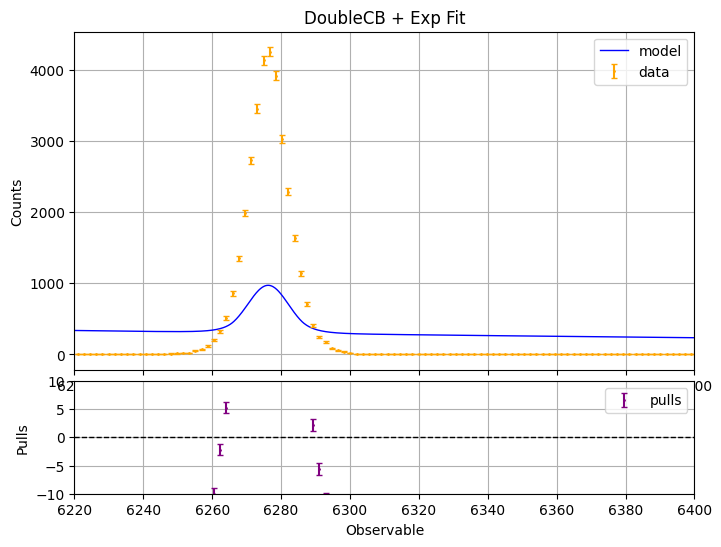

34172


In [11]:
#CREATING INITIAL MODEL
from matplotlib.gridspec import GridSpec 

simu_mass = simu_data['Bc_FullDTF_M']
simu_mass_np = simu_mass.to_numpy()

mass_values = real_data_filtered['Bc_FullDTF_M'].values  
mass_obs = zfit.Space('Bc_FullDTF_M', limits=(6220, 6400))
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

mu_dcb = zfit.Parameter('mu_dcb', 6276.28, 6259, 6290, floating=False)
sigma_dcb = zfit.Parameter('sigma_dcb', 5.86, 1.1, 19, floating=False)
print(f"Initial sigma_dcb: {sigma_dcb.numpy()}")
alpha_dcb_l = zfit.Parameter('alpha_dcb_l', 1.7, 0.1, 5, floating=False)
n_dcb_l = zfit.Parameter('n_dcb_l', 7.77, 5.1, 50, floating=False)
alpha_dcb_r = zfit.Parameter('alpha_dcb_r', 1.61, 0.1, 5, floating=False)
n_dcb_r = zfit.Parameter('n_dcb_r', 11.7, 7.1, 15, floating=False)

dcb = zfit.pdf.DoubleCB(obs=mass_obs, mu=mu_dcb, sigma=sigma_dcb, 
                        alphal=alpha_dcb_l, nl=n_dcb_l, 
                        alphar=alpha_dcb_r, nr=n_dcb_r)

N_sig = zfit.Parameter("N_sig", 18.06, 0, 1e6, floating=False)
dcb_extended = dcb.create_extended(N_sig)

lambda_param = zfit.Parameter("lambda", -0.002, -0.04, -0.0001, floating=False)
exp_pdf = zfit.pdf.Exponential(lambda_param, obs=mass_obs)

N_bkg = zfit.Parameter("N_bkg", 89.63, 0, 1e6, floating=False)
exp_pdf_extended = exp_pdf.create_extended(N_bkg)

supermodel = zfit.pdf.SumPDF([dcb_extended, exp_pdf_extended])

combined_mass = np.concatenate([simu_mass_np, mass_values])  
combined_data = zfit.Data.from_numpy(obs=mass_obs, array=combined_mass)

nll = zfit.loss.UnbinnedNLL(model=supermodel, data=combined_data)

minimizer = zfit.minimize.Minuit()
# result = minimizer.minimize(loss=nll)

plot_model_with_pulls(supermodel, "DoubleCB + Exp Fit", combined_data, 6220, 6400, nbins=100)

# print(result)
print(len(simu_mass)+len(mass_values))

In [12]:
#CREATING FAKE DATASETS
def generate_fake_data(n_samples = 'extended'):
    return supermodel.sample(n=n_samples)

n_experiments=100
datasets = []
for _ in range(n_experiments):
    fake_data = generate_fake_data()
    datasets.append(fake_data)



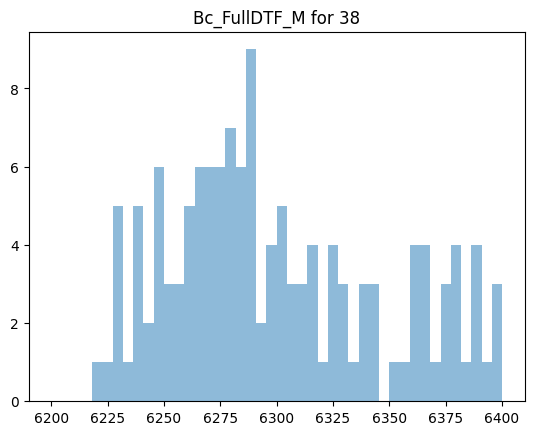

In [12]:
#CHEKING Bc_FullDTF_M DISTRIBUTION
i = random.randint(1, 100)
nbins = 45
bins = np.linspace(6200, 6400, nbins)
bin_width = (6400 - 6200) / nbins

hist, bin_edges = np.histogram(mass_values, bins=bins)
plt.hist(datasets[i]['Bc_FullDTF_M'], bins=bins, alpha=0.5, label="Data")
plt.title(f"Bc_FullDTF_M for {i}")
plt.show()

In [13]:
#CREATING FLOATING MODEL
def creating_model ():
    mass_values = real_data_filtered['Bc_FullDTF_M'].values  
    mass_obs = zfit.Space('Bc_FullDTF_M', limits=(6220, 6400))
    simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

    shift_mu = zfit.Parameter('shift_mu', 0, -12, 12)
    scale_sigma = zfit.Parameter('scale_sigma', 1., 0.1, 1.9, floating=False)

    mu_base = zfit.Parameter('mu_base', 6276.28, 6259, 6290, floating=False)
    mu = zfit.ComposedParameter('mu', lambda mu, shift: mu + shift, params=[mu_base, shift_mu])

    sigma_base = zfit.Parameter('sigma_base', 5.86, 1.1, 19, floating=False)
    sigma = zfit.ComposedParameter('sigma', lambda sigma, scale: sigma * scale, params=[sigma_base, scale_sigma])

    alpha_dcb_l = zfit.Parameter('alpha_dcb_l', 1.7, 0.1, 5, floating=False)
    n_dcb_l = zfit.Parameter('n_dcb_l', 7.77, 5.1, 50, floating=False)
    alpha_dcb_r = zfit.Parameter('alpha_dcb_r', 1.61, 0.1, 5, floating=False)
    n_dcb_r = zfit.Parameter('n_dcb_r', 11.7, 7.1, 15, floating=False)

    dcb = zfit.pdf.DoubleCB(obs=mass_obs, mu=mu, sigma=sigma, 
                            alphal=alpha_dcb_l, nl=n_dcb_l, 
                            alphar=alpha_dcb_r, nr=n_dcb_r)

    N_sig = zfit.Parameter("N_sig", 18.06, 0, 1e6, floating=True)
    dcb_extended = dcb.create_extended(N_sig)

    lambda_param = zfit.Parameter("lambda", -0.002, -0.04, 0.01, floating=True)
    exp_pdf = zfit.pdf.Exponential(lambda_param, obs=mass_obs)

    N_bkg = zfit.Parameter("N_bkg", 89.63, 0, 1e6, floating=True)
    exp_pdf_extended = exp_pdf.create_extended(N_bkg)

    floating_model = zfit.pdf.SumPDF([dcb_extended, exp_pdf_extended])

    combined_mass = np.concatenate([simu_mass_np, mass_values])  
    combined_data = zfit.Data.from_numpy(obs=mass_obs, array=combined_mass)

    # plot_model_with_pulls(floating_model, "DoubleCB + Exp Fit", combined_data, 6220, 6400, nbins=100)

    # print(result)
    # print(len(simu_mass)+len(mass_values))
    return floating_model

In [24]:
# Extract fitted N_sig value and uncertainty
N_sig_param = fit_results[1].params["N_sig"]  # This is a dictionary
N_sig_value = N_sig_param["value"]  # Extract the value from the dictionary

# Access the error using the stored errors in param_errors
N_sig_error = param_errors["N_sig"][1]  # Ensure this index is valid or choose the correct one

# Compute significance
SIGNIFICANCE = (N_sig_value) / N_sig_error
print(f"Significance: {SIGNIFICANCE}")

NameError: name 'fit_results' is not defined

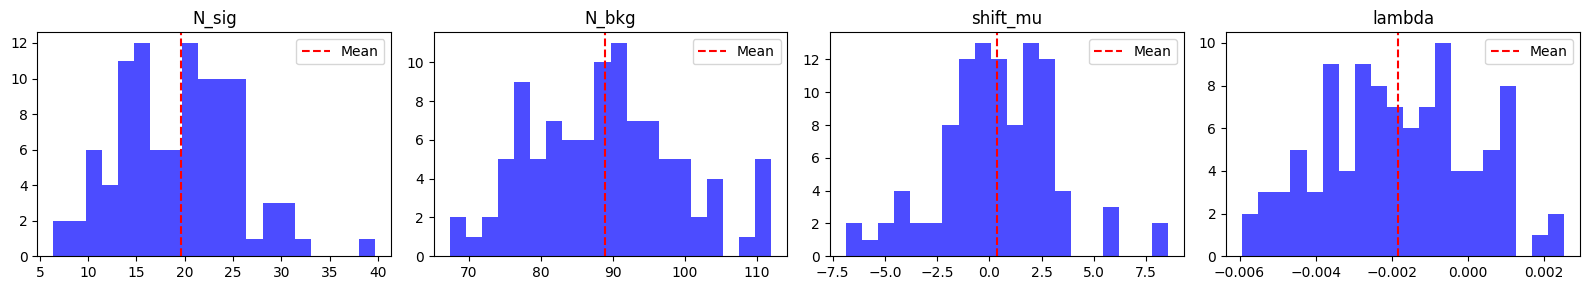

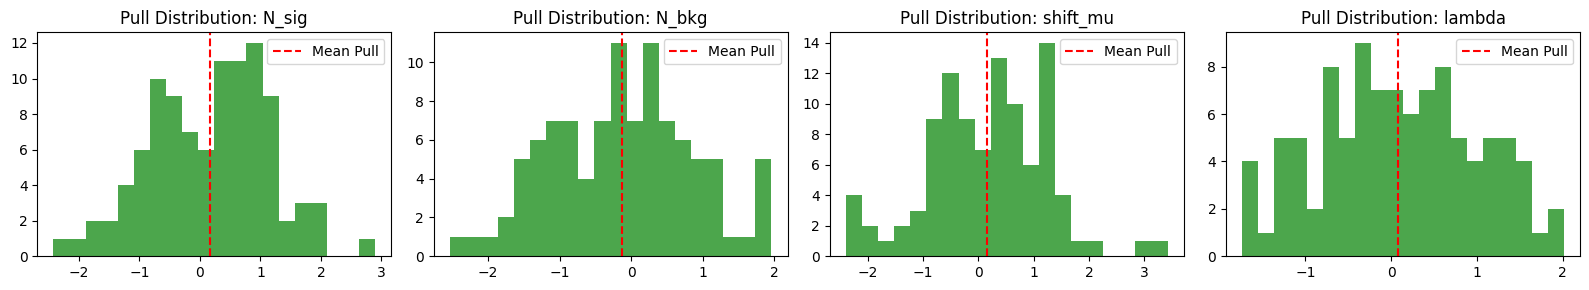

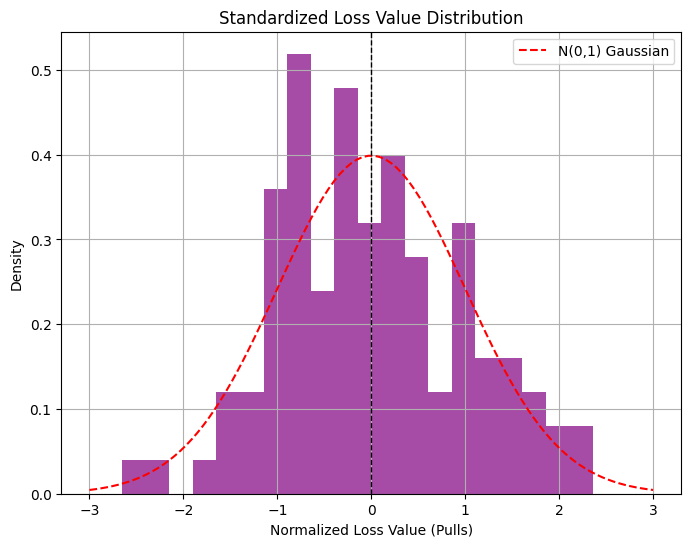

In [26]:
#DATA TESTING
true_params = {
    "shift_mu": 0.,
    "scale_sigma": 1.,
    "mu_base": 6276.28,
    "sigma_base": 5.86,
    "alpha_dcb_l": 1.7,
    "n_dcb_l": 7.77,
    "alpha_dcb_r": 1.61,
    "n_dcb_r": 11.7,
    "N_sig": 18.06,
    "N_bkg": 89.63,
    "lambda": -0.002
}


n = 100 # Number of experiments
fit_results = []
floating_models = []
loss_values = []  # To store loss values
param_values = {}
param_errors = {}

# True parameter values from supermodel (assuming they exist)
# true_params = {param.name: param.numpy() for param in supermodel.get_params()}

# Perform the fits and store results
for i in range(n):
    floating_model = creating_model()
    nll = zfit.loss.ExtendedUnbinnedNLL(model=floating_model, data=datasets[i]['Bc_FullDTF_M'])
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(loss=nll)
    
    fit_results.append(result)
    loss_values.append(result.loss.value())

    # Store parameter values and errors
    if i == 0:  # Initialize storage on first iteration
        param_values = {param.name: [] for param in floating_model.get_params()}
        param_errors = {param.name: [] for param in floating_model.get_params()}

    hesse_errors = result.hesse()
    params = result.params
    for param, values in params.items():
        param_values[param.name].append(values["value"])
        param_errors[param.name].append(hesse_errors[param]["error"])  # Use hesse output


# Calculate pulls
pulls = {
    param: [(param_values[param][i] - true_params[param]) / param_errors[param][i]
            for i in range(n)]
    for param in param_values
}

# Plot parameter distributions
n_params = len(param_values)
n_cols = min(n_params, 4)
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, (param, values) in enumerate(param_values.items()):
    ax = axes[i]
    ax.hist(values, bins=20, alpha=0.7, color='blue')
    ax.axvline(np.mean(values), color='red', linestyle='dashed', label='Mean')
    ax.set_title(param)
    ax.legend()

plt.tight_layout()
plt.show()

# Plot Pull Distributions
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, (param, values) in enumerate(pulls.items()):
    ax = axes[i]
    ax.hist(values, bins=20, alpha=0.7, color='green')
    ax.axvline(np.mean(values), color='red', linestyle='dashed', label='Mean Pull')
    ax.set_title(f"Pull Distribution: {param}")
    ax.legend()

plt.tight_layout()
plt.show()

# Plot Loss Values
# Normalize loss values (if necessary)
loss_mean = np.mean(loss_values)
loss_std = np.std(loss_values)
loss_pulls = [(l - loss_mean) / loss_std for l in loss_values]  # Standardized

# Plot Normalized Loss Distribution
plt.figure(figsize=(8, 6))
plt.hist(loss_pulls, bins=20, alpha=0.7, color='purple', density=True)

# Overlay a standard Gaussian for reference
x = np.linspace(-3, 3, 100)
plt.plot(x, np.exp(-x**2 / 2) / np.sqrt(2 * np.pi), color="red", linestyle="dashed", label="N(0,1) Gaussian")

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Normalized Loss Value (Pulls)")
plt.ylabel("Density")
plt.title("Standardized Loss Value Distribution")
plt.legend()
plt.grid()
plt.show()







/tmp/ktrofimi/ipykernel_2924765/81181372.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


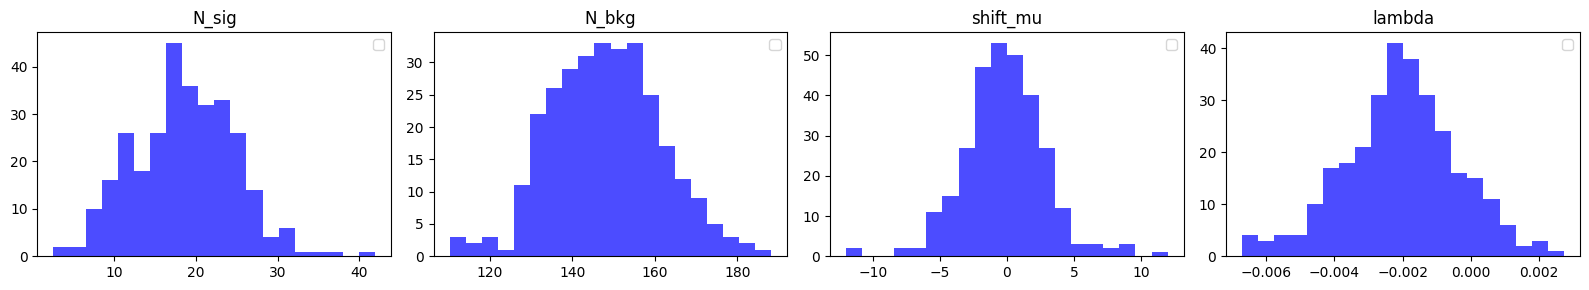

/tmp/ktrofimi/ipykernel_2924765/81181372.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


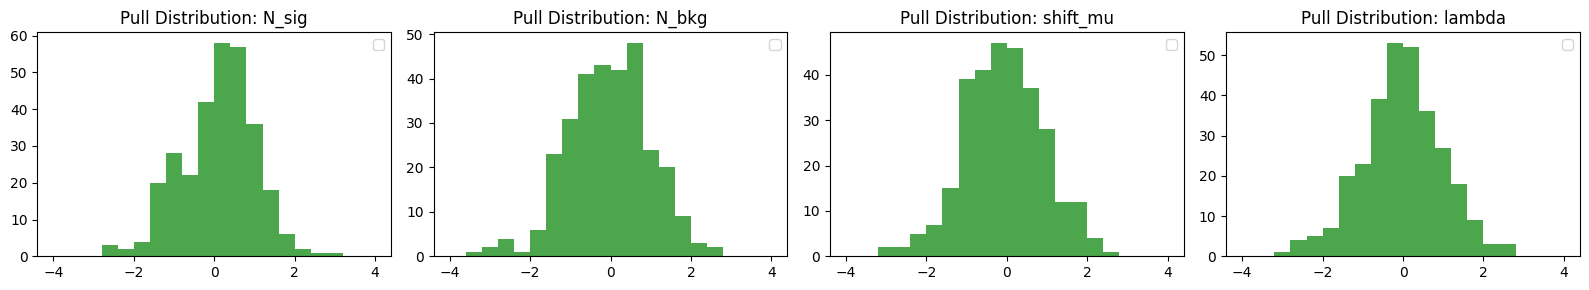

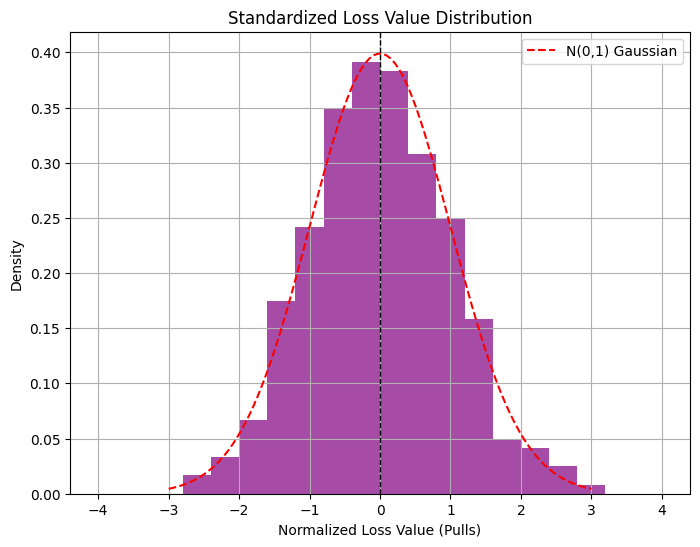

In [25]:
# Plot parameter distributions
n_params = len(param_values)
n_cols = min(n_params, 4)
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, (param, values) in enumerate(param_values.items()):
    ax = axes[i]
    ax.hist(values, bins=20, alpha=0.7, color='blue')
    # ax.axvline(np.mean(values), color='red', linestyle='dashed', label='Mean')
    ax.set_title(param)
    ax.legend()

plt.tight_layout()
plt.show()


lambda_boundary = 0.01
valid_indices = [i for i, val in enumerate(param_values.get("lambda", [])) if val < lambda_boundary]

filtered_pulls = {param: [values[i] for i in valid_indices] for param, values in pulls.items()}

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, (param, values) in enumerate(filtered_pulls.items()):
    ax = axes[i]
    ax.hist(values, bins=20, range=(-4, 4), alpha=0.7, color='green')
    ax.set_title(f"Pull Distribution: {param}")
    ax.legend()

plt.tight_layout()
plt.show()

# Plot Loss Values
# Normalize loss values (if necessary)
loss_mean = np.mean(loss_values)
loss_std = np.std(loss_values)
loss_pulls = [(l - loss_mean) / loss_std for l in loss_values]  # Standardized

# Plot Normalized Loss Distribution
plt.figure(figsize=(8, 6))
plt.hist(loss_pulls, bins=20, alpha=0.7, range = (-4, 4), color='purple', density=True)

# Overlay a standard Gaussian for reference
x = np.linspace(-3, 3, 100)
plt.plot(x, np.exp(-x**2 / 2) / np.sqrt(2 * np.pi), color="red", linestyle="dashed", label="N(0,1) Gaussian")

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Normalized Loss Value (Pulls)")
plt.ylabel("Density")
plt.title("Standardized Loss Value Distribution")
plt.legend()
plt.grid()
plt.show()


In [30]:

mass_obs = zfit.Space('Bc_FullDTF_M', limits=(6220, 6400))
mu_dcb = zfit.Parameter('mu_dcb', 6276.28, floating=False)
sigma_dcb = zfit.Parameter('sigma_dcb', 5.86, floating=False)
alpha_dcb_l = zfit.Parameter('alpha_dcb_l', 1.7, floating=False)
n_dcb_l = zfit.Parameter('n_dcb_l', 7.77, floating=False)
alpha_dcb_r = zfit.Parameter('alpha_dcb_r', 1.61, floating=False)
n_dcb_r = zfit.Parameter('n_dcb_r', 11.7, floating=False)
lambda_param = zfit.Parameter("lambda", -0.002, floating=False)

N_sig_fixed = zfit.Parameter("N_sig", 16.32, floating=False)
N_bkg_fixed = zfit.Parameter("N_bkg", 89.63, floating=False)
N_sig_0 = zfit.Parameter("N_sig_0", 0, floating=False)

dcb = zfit.pdf.DoubleCB(obs=mass_obs, mu=mu_dcb, sigma=sigma_dcb, 
                        alphal=alpha_dcb_l, nl=n_dcb_l, 
                        alphar=alpha_dcb_r, nr=n_dcb_r)
exp_pdf = zfit.pdf.Exponential(lambda_param, obs=mass_obs)

dcb_extended = dcb.create_extended(N_sig_fixed)
dcb_extended_0 = dcb.create_extended(N_sig_0)
exp_pdf_extended = exp_pdf.create_extended(N_bkg_fixed)

supermodel = zfit.pdf.SumPDF([dcb_extended, exp_pdf_extended])
supermodel_bkg_only = zfit.pdf.SumPDF([dcb_extended_0, exp_pdf_extended])

results = []

# Generate 300 toy datasets
for i in range(300):
    toy_signal = dcb_extended.sample(np.random.poisson(N_sig_fixed.value().numpy()))
    toy_background = exp_pdf_extended.sample(np.random.poisson(N_bkg_fixed.value().numpy()))
    toy_mass_np = np.concatenate([toy_signal.numpy(), toy_background.numpy()])
    toy_data = zfit.Data.from_numpy(obs=mass_obs, array=toy_mass_np)

    # Compute likelihoods
    nll_sig_bkg = zfit.loss.UnbinnedNLL(model=supermodel, data=toy_data)
    nll_bkg_only = zfit.loss.UnbinnedNLL(model=supermodel_bkg_only, data=toy_data)

    logL_sig_bkg = nll_sig_bkg.value().numpy()
    logL_bkg_only = nll_bkg_only.value().numpy()
    
    delta_logL = -2 * (logL_bkg_only - logL_sig_bkg)
    significance = np.sqrt(abs(delta_logL))

    results.append({
        "toy": i,
        "logL_sig_bkg": logL_sig_bkg,
        "logL_bkg_only": logL_bkg_only,
        "delta_logL": delta_logL,
        "significance": significance
    })

    print(f"Toy {i+1}/300: Significance = {significance:.2f}σ")

with open("toys_likelihood_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("Simulation complete! Results saved to toys_likelihood_results.json.")


Toy 1/300: Significance = 3.13σ
Toy 2/300: Significance = 4.40σ
Toy 3/300: Significance = 4.24σ
Toy 4/300: Significance = 3.76σ
Toy 5/300: Significance = 4.34σ
Toy 6/300: Significance = 0.74σ
Toy 7/300: Significance = 1.24σ
Toy 8/300: Significance = 3.50σ
Toy 9/300: Significance = 3.28σ
Toy 10/300: Significance = 2.58σ
Toy 11/300: Significance = 3.90σ
Toy 12/300: Significance = 3.30σ
Toy 13/300: Significance = 4.68σ
Toy 14/300: Significance = 2.61σ
Toy 15/300: Significance = 5.22σ
Toy 16/300: Significance = 3.20σ
Toy 17/300: Significance = 3.23σ
Toy 18/300: Significance = 4.25σ
Toy 19/300: Significance = 4.63σ
Toy 20/300: Significance = 2.45σ
Toy 21/300: Significance = 3.08σ
Toy 22/300: Significance = 5.04σ
Toy 23/300: Significance = 3.65σ
Toy 24/300: Significance = 3.66σ
Toy 25/300: Significance = 4.12σ
Toy 26/300: Significance = 2.66σ
Toy 27/300: Significance = 1.17σ
Toy 28/300: Significance = 4.65σ
Toy 29/300: Significance = 4.98σ
Toy 30/300: Significance = 3.48σ
Toy 31/300: Signifi

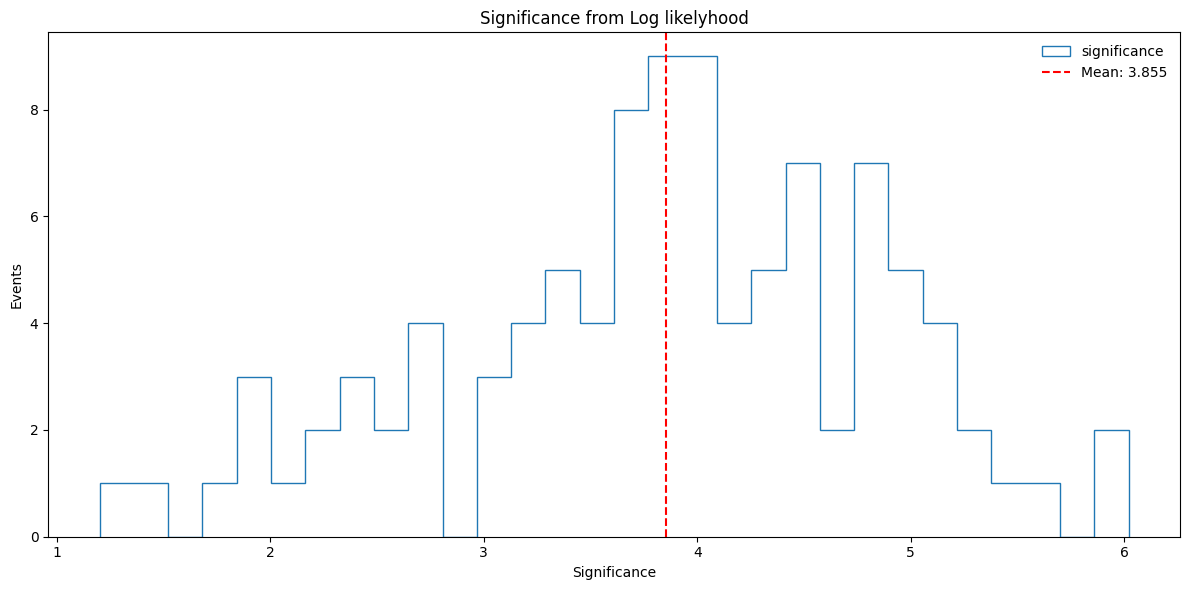

In [19]:
import json
with open("toys_likelihood_results_neww.json", "r") as f:
    results = json.load(f)

significances = [entry["significance"] for entry in results]
mean_significance = np.mean(significances)
# Create the histogram
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(significances, bins=30, histtype='step', label='significance')
ax.axvline(mean_significance, color='red', linestyle='--', label=f'Mean: {mean_significance:.3f}')

ax.set_xlabel('Significance')
ax.set_ylabel('Events')
ax.set_title('Significance from Log likelyhood')
ax.legend(frameon=False)


plt.tight_layout()
plt.show()

In [ ]:
#_________LOG_LIKELIHOOD____________
mass_values = real_data_filtered['Bc_FullDTF_M'].values  
mass_obs = zfit.Space('Bc_FullDTF_M', limits=(6220, 6400))
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

shift_mu = zfit.Parameter('shift_mu', 0, -12, 12, floating=True)
scale_sigma = zfit.Parameter('scale_sigma', 1., 0.1, 1.9, floating=False)

mu_base = zfit.Parameter('mu_base', 6276.28, 6259, 6290, floating=False)
mu = zfit.ComposedParameter('mu', lambda mu, shift: mu + shift, params=[mu_base, shift_mu])

sigma_base = zfit.Parameter('sigma_base', 5.86, 1.1, 19, floating=False)
sigma = zfit.ComposedParameter('sigma', lambda sigma, scale: sigma * scale, params=[sigma_base, scale_sigma])

alpha_dcb_l = zfit.Parameter('alpha_dcb_l', 1.7, 0.1, 5, floating=False)
n_dcb_l = zfit.Parameter('n_dcb_l', 7.77, 5.1, 50, floating=False)
alpha_dcb_r = zfit.Parameter('alpha_dcb_r', 1.61, 0.1, 5, floating=False)
n_dcb_r = zfit.Parameter('n_dcb_r', 11.7, 7.1, 15, floating=False)

dcb = zfit.pdf.DoubleCB(obs=mass_obs, mu=mu, sigma=sigma, 
                        alphal=alpha_dcb_l, nl=n_dcb_l, 
                        alphar=alpha_dcb_r, nr=n_dcb_r)

N_sig = zfit.Parameter("N_sig", 18.06, 0, 1e6, floating=True)
dcb_extended = dcb.create_extended(N_sig)

lambda_param = zfit.Parameter("lambda", -0.002, -0.04, -0.0001, floating=True)
exp_pdf = zfit.pdf.Exponential(lambda_param, obs=mass_obs)

N_bkg = zfit.Parameter("N_bkg", 89.63, 0, 1e6, floating=True)
exp_pdf_extended = exp_pdf.create_extended(N_bkg)

full_model = zfit.pdf.SumPDF([dcb_extended, exp_pdf_extended])

# Background-only model (no signal part, but N_bkg is floating)
lambda_param_bckg = zfit.Parameter("lambda_bckg", -0.002, -0.04, -0.0001, floating=True)
exp_pdf_bckg = zfit.pdf.Exponential(lambda_param_bckg, obs=mass_obs)

N_just_bkg = zfit.Parameter("N_bkg_bckg", 89.63, 0, 1e6, floating=True)  
bkg_only_model = exp_pdf_bckg.create_extended(N_just_bkg)

minimizer = zfit.minimize.Minuit() 
results = []

for i, toy_data in enumerate(datasets):

    nll_sig_bkg = zfit.loss.UnbinnedNLL(model=full_model, data=toy_data)
    result_sig_bkg = minimizer.minimize(nll_sig_bkg)
    logL_sig_bkg = nll_sig_bkg.value().numpy()

    nll_bkg_only = zfit.loss.UnbinnedNLL(model=bkg_only_model, data=toy_data)

    result_bkg_only = minimizer.minimize(nll_bkg_only, params=[N_just_bkg])
    logL_bkg_only = nll_bkg_only.value().numpy()

    delta_logL = -2 * (logL_bkg_only - logL_sig_bkg)
    significance = np.sqrt(abs(delta_logL))

    results.append({
        "toy": i,
        "logL_sig_bkg": logL_sig_bkg,
        "logL_bkg_only": logL_bkg_only,
        "delta_logL": delta_logL,
        "significance": significance
    })
    print(f"Toy {i+1}/100: Significance = {significance:.2f}")

with open("toys_likelihood_results_neww.json", "w") as f:
    json.dump(results, f, indent=4)

print(" Done! Results saved in 'toys_likelihood_results_neww.json'")


In [19]:
import zfit
from zfit.loss import ExtendedUnbinnedNLL
from zfit.minimize import Minuit
from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests import Discovery
from hepstats.hypotests.parameters import POI
import json

#_________LOG_LIKELIHOOD____________
mass_values = real_data_filtered['Bc_FullDTF_M'].values  
mass_obs = zfit.Space('Bc_FullDTF_M', limits=(6220, 6400))
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

shift_mu = zfit.Parameter('shift_mu', 0, -12, 12, floating=True)
scale_sigma = zfit.Parameter('scale_sigma', 1., 0.1, 1.9, floating=False)

mu_base = zfit.Parameter('mu_base', 6276.28, 6259, 6290, floating=False)
mu = zfit.ComposedParameter('mu', lambda mu, shift: mu + shift, params=[mu_base, shift_mu])

sigma_base = zfit.Parameter('sigma_base', 5.86, 1.1, 19, floating=False)
sigma = zfit.ComposedParameter('sigma', lambda sigma, scale: sigma * scale, params=[sigma_base, scale_sigma])
alpha_dcb_l = zfit.Parameter('alpha_dcb_l', 1.7, 0.1, 5, floating=False)
n_dcb_l = zfit.Parameter('n_dcb_l', 7.77, 5.1, 50, floating=False)
alpha_dcb_r = zfit.Parameter('alpha_dcb_r', 1.61, 0.1, 5, floating=False)
n_dcb_r = zfit.Parameter('n_dcb_r', 11.7, 7.1, 15, floating=False)

dcb = zfit.pdf.DoubleCB(obs=mass_obs, mu=mu, sigma=sigma, 
                        alphal=alpha_dcb_l, nl=n_dcb_l, 
                        alphar=alpha_dcb_r, nr=n_dcb_r)

N_sig = zfit.Parameter("N_sig", 18.06, 0, 1e6, floating=True)
dcb_extended = dcb.create_extended(N_sig)
lambda_param = zfit.Parameter("lambda", -0.002, -0.04, -0.0001, floating=True)
exp_pdf = zfit.pdf.Exponential(lambda_param, obs=mass_obs)
N_bkg = zfit.Parameter("N_bkg", 89.63, 0, 1e6, floating=True)
exp_pdf_extended = exp_pdf.create_extended(N_bkg)
full_model = zfit.pdf.SumPDF([dcb_extended, exp_pdf_extended])

results = []
for i, toy_data in enumerate(datasets):
    loss = ExtendedUnbinnedNLL(model=full_model, data=toy_data)
    calculator = AsymptoticCalculator(input=loss, minimizer=Minuit())
    poinull = POI(N_sig, 0)
    discovery_test = Discovery(calculator, poinull)
    result = discovery_test.result()
    
    significance = float(result[1])  # Extract the second value and convert to float
    results.append({
        "toy": i,
        "significance": significance
    })
    print(f"Toy {i+1}: Significance = {significance:.2f}")

with open("toys_likelihood_results_neww.json", "w") as f:
    json.dump(results, f, indent=4)

print("Done! Results saved in 'toys_likelihood_results_neww.json'")


Toy 1: Significance = 3.18
Toy 2: Significance = 1.20
Toy 3: Significance = 5.35
Toy 4: Significance = 3.37
Toy 5: Significance = 4.88
Toy 6: Significance = 4.78
Toy 7: Significance = 4.40
Toy 8: Significance = 1.99
Toy 9: Significance = 4.93
Toy 10: Significance = 3.25
Toy 11: Significance = 3.90
Toy 12: Significance = 3.84
Toy 13: Significance = 3.76
Toy 14: Significance = 2.41
Toy 15: Significance = 2.57
Toy 16: Significance = 2.22
Toy 17: Significance = 2.79
Toy 18: Significance = 6.02
Toy 19: Significance = 4.04
Toy 20: Significance = 4.55
Toy 21: Significance = 3.63
Toy 22: Significance = 4.15
Toy 23: Significance = 4.55
Toy 24: Significance = 3.98
Toy 25: Significance = 5.00
Toy 26: Significance = 2.75
Toy 27: Significance = 2.66
Toy 28: Significance = 3.82
Toy 29: Significance = 4.89
Toy 30: Significance = 4.55
Toy 31: Significance = 3.74
Toy 32: Significance = 5.12
Toy 33: Significance = 2.17
Toy 34: Significance = 3.77
Toy 35: Significance = 4.08
Toy 36: Significance = 3.83
T